# **Invent objects from a chosen subject and directly produce Bounding Boxes**

In [ ]:
from huggingface_hub import InferenceClient

output = ""
image_size = (1920, 1080)
background_prompt = "nature"
token = "Insert token"

# Define the prompt for generating bounding box details
user_prompt = (f"Given an image size of {image_size} pixels with the theme: '{background_prompt}', "
               "provide the positions and sizes of 3 items within the scene. Each item should have a "
               "reasonable size and position relative to the image dimensions (make them big). Format the output as: "
               "x: (x-coordinate), y: (y-coordinate), w: (width), h: (height), prompt: (item description).")


client = InferenceClient(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    token=token,
)

# Prompt for generating bounding box details
for message in client.chat_completion(
    messages=[{"role": "user", "content": f"{user_prompt}"}],
    max_tokens=500,
    stream=True,
):
    print(message.choices[0].delta.content, end="")
    output += message.choices[0].delta.content




# Process the output to fit the bounding box format
items = output.splitlines()  # assuming model outputs one item per line
bounding_boxes = []

# Generate bounding boxes based on output
for item in items:
    try:
        # Parse the coordinates and prompt from the output
        parts = item.split(",")
        x = int(parts[0].split(":")[1].strip())
        y = int(parts[1].split(":")[1].strip())
        w = int(parts[2].split(":")[1].strip())
        h = int(parts[3].split(":")[1].strip())
        prompt = parts[4].split(":")[1].strip()

        # Add the bounding box to the list
        bounding_boxes.append({'x': x, 'y': y, 'w': w, 'h': h, 'prompt': prompt})
    except (IndexError, ValueError):
        # print(f"Skipping item due to parsing error: {item}")
        continue

# Output the final result
final_output = {
    "image_size": image_size,
    "background_prompt": background_prompt,
    "bounding_boxes": bounding_boxes
}

# Print the output as a Python dictionary
print(final_output)


Here are the positions and sizes of 3 items within the scene:

**Item 1:** 
x: 250, y: 150, w: 800, h: 600, prompt: "Tree"

This tree is positioned in the left-top corner of the image and spans 800 pixels in width and 600 pixels in height, making it a dominant element in the scene.

**Item 2:** 
x: 1200, y: 500, w: 400, h: 800, prompt: "Mountain"

This mountain is situated in the center-right part of the image and stretches 400 pixels in width and 800 pixels in height, providing a striking contrast to the expansive sky above.

**Item 3:** 
x: 50, y: 800, w: 1500, h: 200, prompt: "River"

This river runs along the bottom-left edge of the image, occupying a significant width of 1500 pixels and a height of 200 pixels, providing a sense of flow and movement through the landscape.{'image_size': (1920, 1080), 'background_prompt': 'nature', 'bounding_boxes': [{'x': 250, 'y': 150, 'w': 800, 'h': 600, 'prompt': '"Tree"'}, {'x': 1200, 'y': 500, 'w': 400, 'h': 800, 'prompt': '"Mountain"'}, {'x': 

## **Ploting Bounding Boxes**

Tree 250 1050 150 750
Mountain 1200 1300 600 2300
River 50 1550 1550 1000


<ipython-input-35-95f50c6bd8d8>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(items_with_boxes))  # 'tab10' provides 10 distinct colors


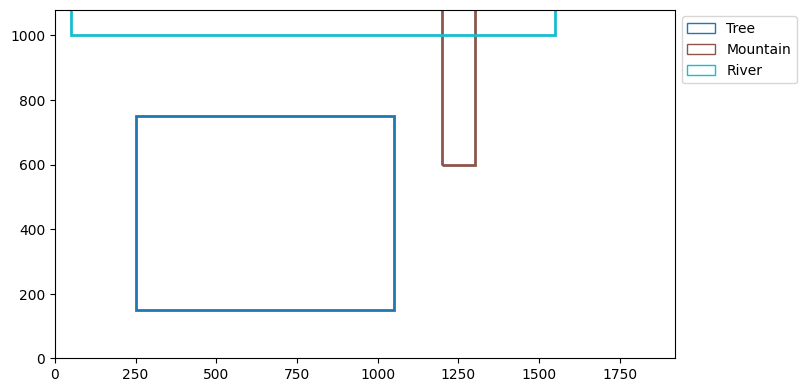

In [ ]:
output5 = ""
for message2 in client.chat_completion(

    messages=[{"role": "user", "content": f"Make a list of the items names and thier bounding boxes (in the format: 1. **item**: [x left, x right, y down, y up]) from the description: {final_output}."}],
    max_tokens=500,
    stream=True,
):
    output5 += message2.choices[0].delta.content

import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np



# Extract item names and bounding boxes using regex
item_pattern = r"(\d+)\.\s*\*\*(.*?)\*\*:\s*\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]"
matches = re.findall(item_pattern, output5)

# Prepare a list to hold the extracted information
items_with_boxes = []

for match in matches:
    item_index, item_name, x_left, x_right, y_down, y_up = match
    items_with_boxes.append({
        'name': item_name,
        'bbox': [int(x_left), int(x_right), int(y_down), int(y_up)]
    })
    print(item_name, int(x_left), int(x_right), int(y_down), int(y_up))

# Plotting the bounding boxes
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.set_xlim([0, 1920])
ax.set_ylim([0, 1080])
ax.imshow([[1]], extent=[0, 768, 0, 768], cmap='gray', vmin=0, vmax=1)

# Generate a colormap with different colors
colors = plt.cm.get_cmap('tab10', len(items_with_boxes))  # 'tab10' provides 10 distinct colors

# Add bounding boxes and labels to a legend
legend_patches = []

for idx, item in enumerate(items_with_boxes):
    bbox = item['bbox']
    name = item['name']

    # Draw bounding box with different colors
    rect = patches.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0], bbox[3] - bbox[2],
                             linewidth=2, edgecolor=colors(idx), facecolor='none')
    ax.add_patch(rect)

    # Add legend entry
    legend_patches.append(patches.Patch(edgecolor=colors(idx), facecolor='none', label=name))

# Add legend outside the plot
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))


plt.show()


# **Transform output5 format**

In [ ]:
import re

def parse_and_transform(input_string, theme):
    bounding_boxes = []

    # Regular expression pattern to match item name and bounding box
    pattern = r'\*\*(.*?)\*\*: \[(\d+), (\d+), (\d+), (\d+)\]'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    # Loop over matches and extract the necessary data
    for match in matches:
        name = match[0]  # Extract item name
        x1, x2, y1, y2 = map(int, match[1:])  # Extract bounding box coordinates and convert to int

        # Calculate width (w) and height (h)
        w = x2 - x1
        h = y2 - y1

        # Create dictionary with the transformed format
        bounding_box = {
            'x': x1,
            'y': y1,
            'w': w,
            'h': h,
            'prompt': name
        }

        # Add to the list of bounding boxes
        bounding_boxes.append(bounding_box)

    # Output result
    output = {
        'theme': theme,
        'bounding_boxes': bounding_boxes
    }

    return output



bounding_boxes = parse_and_transform(output5,background_prompt)
print(bounding_boxes)

{'theme': 'nature', 'bounding_boxes': [{'x': 250, 'y': 150, 'w': 800, 'h': 600, 'prompt': 'Tree'}, {'x': 1200, 'y': 600, 'w': 100, 'h': 1700, 'prompt': 'Mountain'}, {'x': 50, 'y': 1550, 'w': 1500, 'h': -550, 'prompt': 'River'}]}


In [ ]:
import json


def create_config(image_size, bounding_boxes, background_prompt):


    # Background configuration
    bbox_controls = [{
        "enable": True,
        "x": 0,
        "y": 0,
        "w": 1,
        "h": 1,
        "prompt": background_prompt,
        "neg_prompt": "watermark, bad, ugly, low quality, cartoonish, text, blurry",
        "blend_mode": "Background",
        "feather_ratio": 0.2,
        "seed": 0
    }]

    # Bounding boxes configurations
    for box in bounding_boxes:
        box_config = {
            "enable": True,
            "x": box['x'] / image_size[0],  # Normalize x
            "y": box['y'] / image_size[1],  # Normalize y
            "w": box['w'] / image_size[0],  # Normalize width
            "h": box['h'] / image_size[1],  # Normalize height
            "prompt": box['prompt'],
            "neg_prompt": "watermark, bad, ugly, low quality, cartoonish, text, blurry",
            "blend_mode": "Foreground",
            "feather_ratio": 0.2,
            "seed": box.get("seed", -1)  # Default seed to -1 if not provided
        }
        bbox_controls.append(box_config)

    # Full configuration
    config = {
        "bbox_controls": bbox_controls
    }

    # Save the configuration as a JSON file
    config_filename = f"{background_prompt}.json"
    with open(config_filename, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"Configuration saved as {config_filename}")


In [ ]:
# Generate configuration
create_config(image_size, bounding_boxes['bounding_boxes'], background_prompt)

Configuration saved as nature.json
